##### Imports

In [1]:
%%capture
!pip install ipympl

In [2]:
from google.colab import output
output.enable_custom_widget_manager()

In [3]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
#import matplotlib.pyplot as plt
#from matplotlib import cm

# Supervised Learning

## Formal Definition

A supervised learning algorithm requires a dataset $D = \{ (x_1, y_1), ..., (x_n, y_n) \}$ where $x_i$ is a d-dimensional input vector for an algorithm (or **feature vector**), and $y_i$ the corresponding output (or **label**). We assume that these data points are drawn from an unknown distribution $\mathcal{P}$, so

$$(x_i,y_i) \sim \mathcal{P}$$

where we want $(x_i, y_i)$ to be iid. We can formalize this by saying:

$$D = \{(x_1, y_1),...,(x_n,y_n)\} ⊆ \mathbb{R}^d × \mathcal{C}$$

where

* $n$ is the size of our dataset
* $\mathbb{R}^d$ is the d-dimensional feature space
* $x_i$ is the feature vector of the $i^{th}$ example
* $y_i$ is the label of the $i^{th}$ example
* $\mathcal{C}$ is the space of all possible labels, or label space.

The goal of supervised machine learning can be summed up as finding a function $h:\mathbb{R}^d \rightarrow \mathcal{C}$, such that for every new input/output pair $(x,y)$ sampled from $\mathcal{P}$ we have $h(x)\approx y$.


### Label Spaces Examples
* *Binary Classification*: Say we're building a spam filter. Here we have to classes, spam and not spam. The label space is often $\{0,1\}$ or $\{-1,1\}$. The choice impacts how we write our loss function, but we'll see more on that later on.
* *Multi-class Classification*: If we want to build an image classifier, we need to specify which classes we're interested in (e.g. 1=cat, 2=dog, etc.). If we have $K$ image classes, we have $C=\{1,2,…,K\}$.
* *Regression*: If we want to predict the daily temperature, we're predicting a number which could take any value, even if some are highly improbable. In this case $\mathcal{C}=\mathbb{R}$.

### Feature Spaces Examples
* *Housing Prices*: If we're building a model to predict house sale prices, we might create $x_i=(x_{i_1},x_{i_2},…,x_{i_d})$ where $x_{i_1}$ is the surface area in $m^2$, $x_{i_2}$ is the number of years ago the house was built, longitude and latitude, etc. In this case we have "hand-crafted" features, each chosen by the modeler.
* *Text Document*: For something like email classification, a common feature space is the so called bag-of-words. First we find all $d$ unique words over all the documents we have. We then create the vector $x_i=(x_{i_1},x_{i_2},…,x_{i_d})$ for each document $i$, where each element $x_{i_j}$ tells us how often word $j$ appears in document $i$.

# A polynomial example

Many of the basic concepts and much of the terminology can be introduced in the context of a simple example involving the fitting of a polynomial to a small synthetic data set. So let's start!


> *One of the most important modules we will use is NumPy, a Python package for scientific computing. NumPy provides a multidimensional array object, various derived objects, and an assortment of routines for fast operations on arrays, including mathematical, shape manipulation, sorting, and basic linear algebra.*



In [4]:
import numpy as np

We set the seed of the NumPy random generator to ensure repeatability.

In [9]:
seed=42
np.random.seed(seed)

We will sample $n$ real values from the uniform distribution $U[0,1)$. This sample will represent our 1-dimensional feature matrix.

In [10]:
n = 10

X = np.random.random_sample(n)

In [11]:
X

array([0.37454012, 0.95071431, 0.73199394, 0.59865848, 0.15601864,
       0.15599452, 0.05808361, 0.86617615, 0.60111501, 0.70807258])

We generate labels, we want to predict, with $\sin{(2 \pi x)}$ and add some additive white Gaussian noise (AWGN).

In [12]:
y = np.sin(2.*np.pi*X) + np.random.normal(0, 0.1,n)

In many cases, we will not be able to perfectly predict the exact output given the input, due to lack of knowledge of the input-output mapping (called **model uncerainty**) and/or due to intrinsic stochasticity in the mapping (called **data uncertainty**). Here, we add noise to simulate uncerainty about the underlying function, we want to predict.

Let's visualize our data points.

> *We will mainly use Matplotlib for data visualization, a comprehensive library for creating static, animated, and interactive visualizations in Python.*

In [13]:
import matplotlib.pyplot as plt

We generate sufficient data points to visualize our underlying function, we want to approximate.

In [14]:
X_sin = np.arange(0, 1, 0.01)
y_sin = np.sin(2*np.pi*X_sin)

Now we can plot our input/output pairs and the function to approximate.

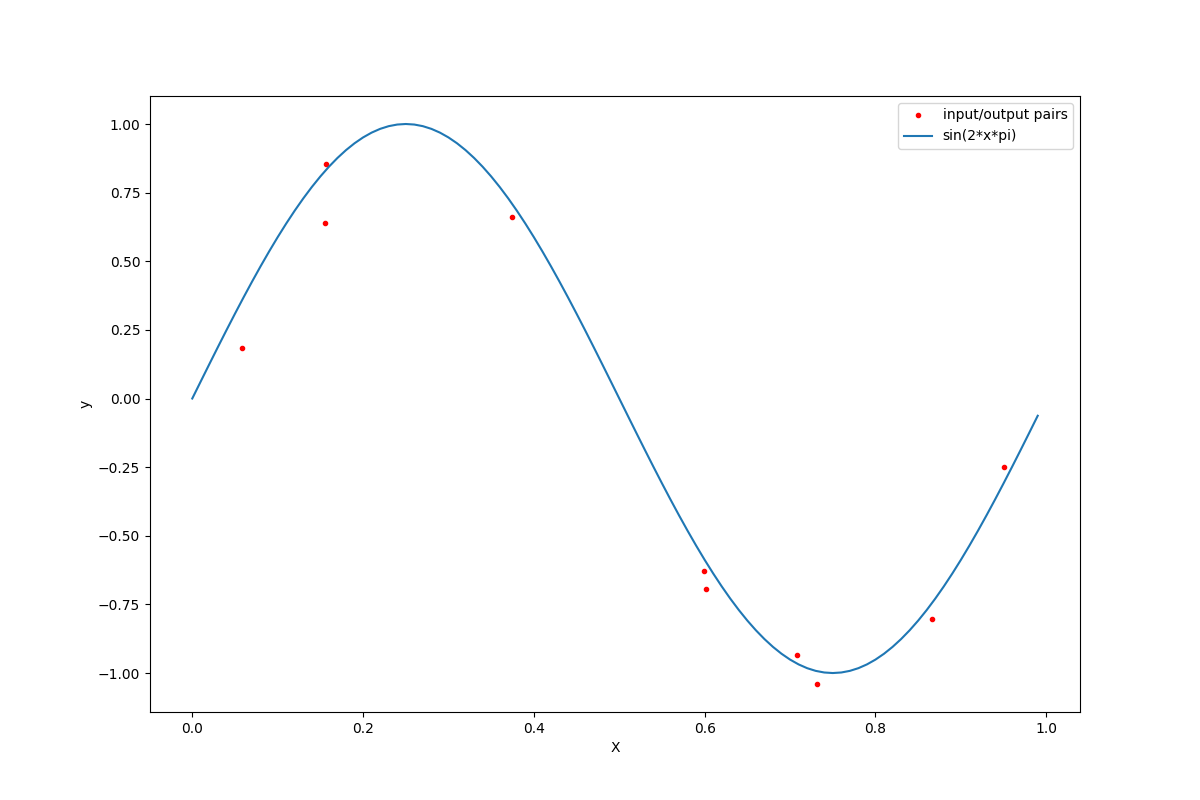

In [15]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(X, y, 'r.', label='input/output pairs')
ax.plot(X_sin, y_sin, label='sin(2*x*pi)')
ax.set_xlabel("X")
ax.set_ylabel("y")
ax.legend()

We start rather infromally and consider a simple approach on curve fitting. In particular, we will fit the our data using a polynomial function of the form of

$$\hat{y}(x, w) = w_0 + w_1 x + w_2 x^2 + ... + w_M x^M = \sum_{j=0}^{M} w_j x^j $$

where $M$ is the ***order*** of the polynomial, and $x^j$ denotes $x$ raised to the power of $j$. The polynomial coefficients $w_0, ..., w_M$ are collectively denoted by the vector w.

The values of the coefficients will be determined by fitting the polynomial to the training data. This can be done by minimizing an ***error function*** that measures the misfit between the function $\hat{y}(x,w)$, for any given value of $w$, and the training set data points.

One simple choice of error function, which is widely used, is the sum of the squares of the difference between the predictions for each data point $x_n$ and the corresponding target value $y_n$, given by

$$E(w) = \frac{1}{2} \sum_{n=1}^{N} (\hat{y}(x_n,w) - y_n)^2$$

where the factor $\frac{1}{2}$ is included for later convenience and can be derived from probability theory.

We note that the error function has a non-negative quantity that would be zero iff the function $\hat{y}(x,w)$ were to pass exactly through each training data point.

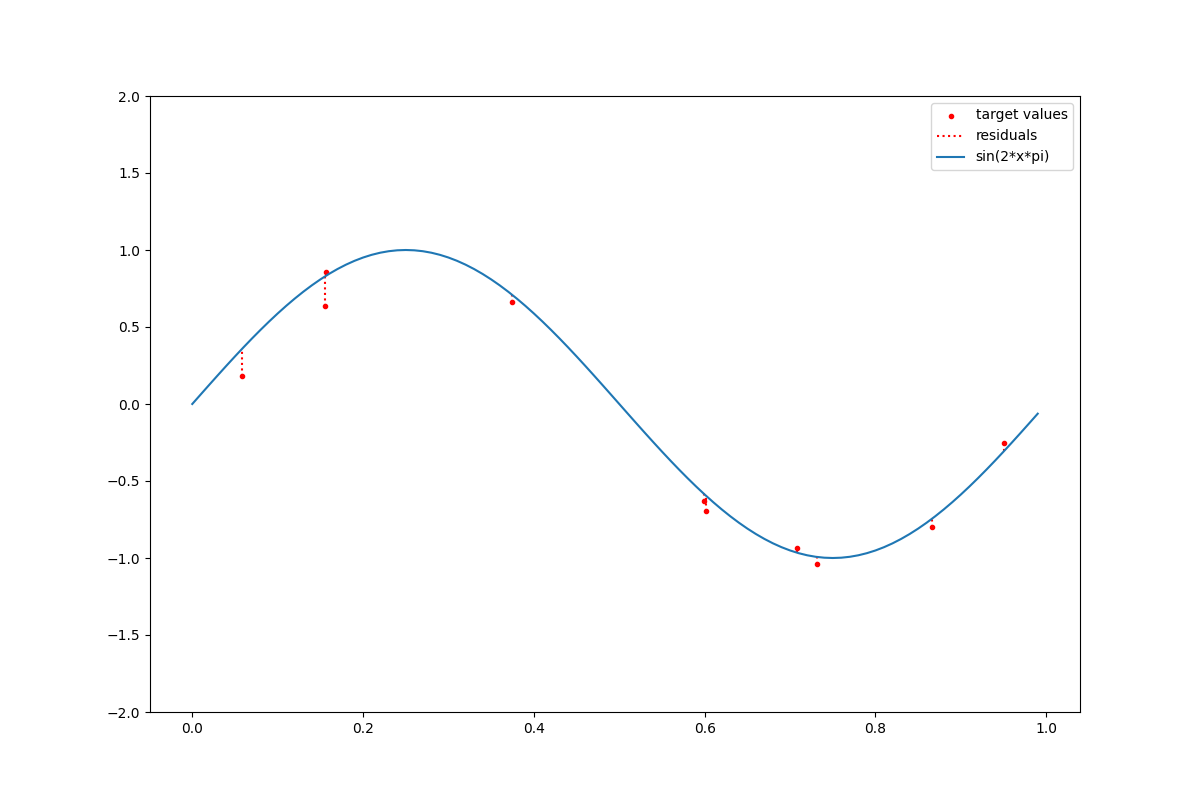

In [16]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(X,y, color="red", marker=".", label='target values')
for x_val, y_val in zip(X, y):
    y_sin_val = np.sin(2*np.pi*x_val)
    lines = plt.vlines(x = x_val, ymin=min(y_val, y_sin_val), ymax=max(y_val, y_sin_val) , color = 'r', linestyles=":")
lines.set_label("residuals")
ax.plot(X_sin, y_sin, label='sin(2*x*pi)')
ax.set_ylim(bottom=-2, top=2)
ax.legend()

There remains the problem of choosing the order $M$ of the polynomial. This is an example of an important concept called *model selection*.

Let's try to fit polynomials of the orders $M = 0, 1, 3$ and $9$ to our data set.

In [27]:
order = 9

polyreg = Pipeline([('p_features', PolynomialFeatures(order)), ('reg', LinearRegression())])
polyreg.fit(X.reshape(-1, 1),y.reshape(-1, 1))
X_reg_curve = np.linspace(0, 1, 300).reshape(-1, 1)
y_reg_curve = polyreg.predict(X_reg_curve)
y_reg = polyreg.predict(X.reshape(-1, 1))

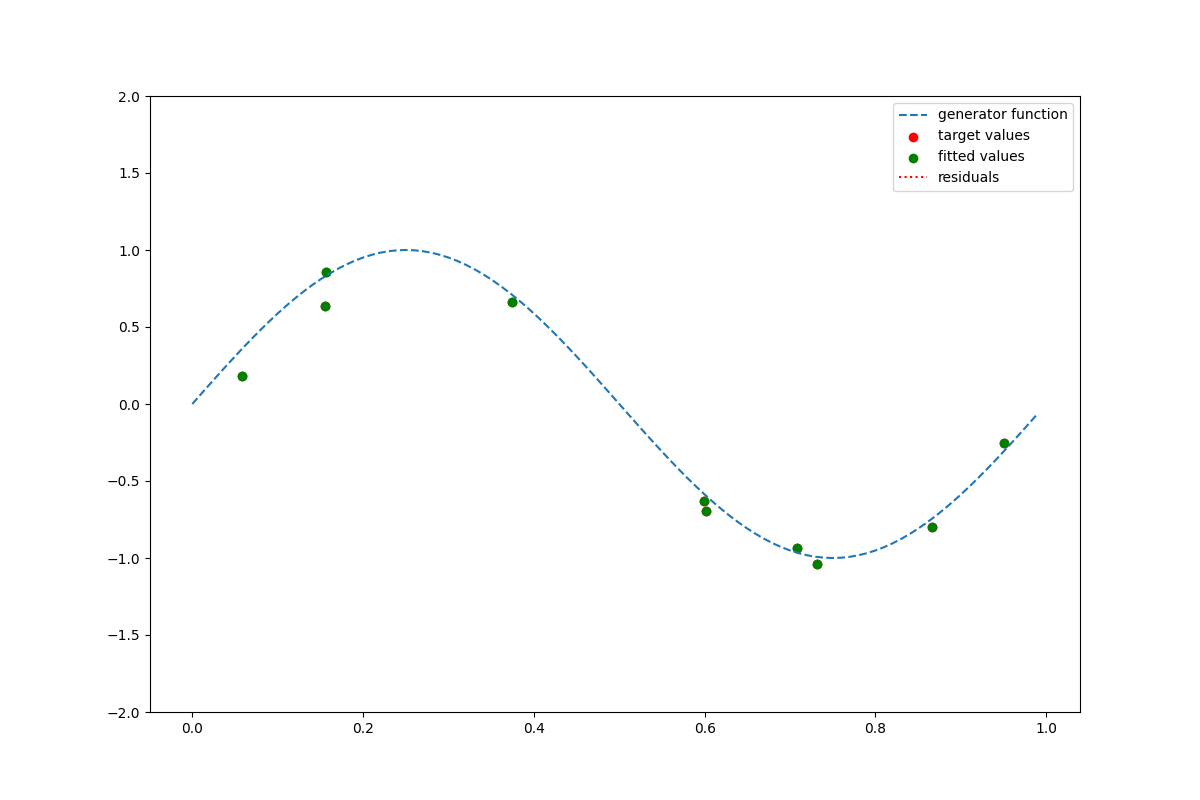

In [28]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(X_sin, y_sin, linestyle='--', label='generator function')
ax.scatter(X,y, color="red", marker="o", label='target values')
ax.scatter(X,y_reg, color="green", marker="o", label='fitted values')
for x_val, y_val, y_reg_val  in zip(X, y, y_reg):
    lines = plt.vlines(x = x_val, ymin=min(y_val, y_reg_val), ymax=max(y_val, y_reg_val) , color = 'r', linestyles=":")
lines.set_label("residuals")
ax.set_ylim(bottom=-2, top=2)
ax.legend()
plt.show()

We can calculate the sum of squares to get a numerical value of our fit.

In [29]:
0.5 * np.sum((y.reshape(-1, 1) - y_reg)**2)

8.036041279795819e-16

We can also visualize the entire fitted curve.

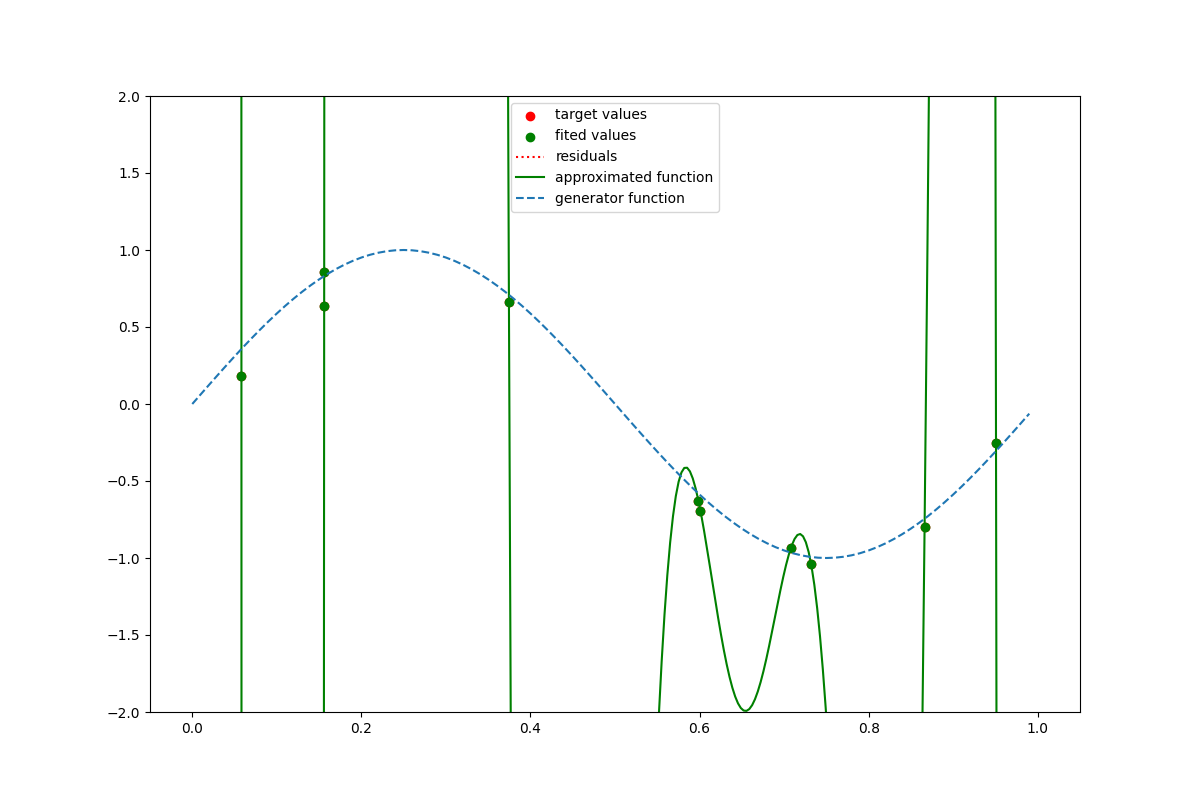

In [30]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(X,y, color="red", marker="o", label='target values')
ax.scatter(X, y_reg, color="green", marker="o", label='fited values')
for x_val, y_val, y_reg_val in zip(X, y, y_reg.reshape((-1, ))):
    lines = plt.vlines(x = x_val, ymin=min(y_val, y_reg_val), ymax=max(y_val, y_reg_val) , color = 'r', linestyles=":")
lines.set_label("residuals")
ax.plot(X_reg_curve, y_reg_curve, color="green", label='approximated function')
ax.plot(X_sin, y_sin, linestyle='--', label='generator function')
ax.set_ylim(bottom=-2, top=2)
ax.legend()

When we use a high polynomial order ($M=9$), we obtain a excellent fit to the training data. In fact, the polynomial passes exactly through each data point and $E(w^*) = 0$. However the fitted curve oscillates wildly and gives a very poor presentation of the underlying function, we want to approximate. This beahaviour is known as ***over-fitting***.

Our goal is to achieve good ***generalization*** by making accurate predictions for new data. We can obtain some quantitative insight into the dependence of the generalization performance on $M$ by considering a seperate set of data known as ***test set***, comprising of 100 data points generated using the same procedure as used to generate the training set points.

In [31]:
m = 100

X_test = np.random.random_sample(m, )
y_test = np.sin(2.*np.pi*X_test) + np.random.normal(0, 0.1,m)

In this example we can simply generate a new test set as we know the distribution for our data points. However, this approach naturaly falls short in real world scenarios, since we actually want to approximate this underlying generator function.

Usually you split an existing dataset in a training set, used for model training and a test set with unseen data points for the model.
The ratio of training and test examples depends on the quantity of your labeled instances, the chosen model, and the problem domain.

As a rule of thumb we can use a split of 80% of all instances in our dataset for training and set aside 20% of our data for testing.



For each value of $M$, we can evaluate the residual value of $E(w^*)$ for the training data, and we can also evaluate $E(w^*)$ for the test data set. Instead of evaluating the error function $E(w)$ it is sometimes more convenient to use the root-mean-squared (**RMS**) error defined by

$$E_{RMS} = \sqrt{\frac{1}{N} \sum_{n=1}^{N} (\hat{y}(x_n, w) - y_n)^2}$$

in which the division by $N$ allows us to compare different sizes of data sets on an equal footing, and the square root ensures that $E_{RMS}$ is measured on the same scale as the target variable $y$.

In [32]:
rmse = lambda predictions, targets: np.sqrt(np.mean((predictions - targets)**2))

In [33]:
orders = []
rmse_train = []
rmse_test = []

for i in range(0, 10):
    polyreg = Pipeline([('p_features', PolynomialFeatures(i)), ('reg', LinearRegression())])
    polyreg.fit(X.reshape(-1, 1),y.reshape(-1, 1))
    y_reg = polyreg.predict(X.reshape(-1, 1))
    y_reg_test = polyreg.predict(X_test.reshape(-1, 1))
    orders.append(i)
    rmse_train.append(rmse(y_reg, y.reshape(-1, 1)))
    rmse_test.append(rmse(y_reg_test, y_test.reshape(-1, 1)))

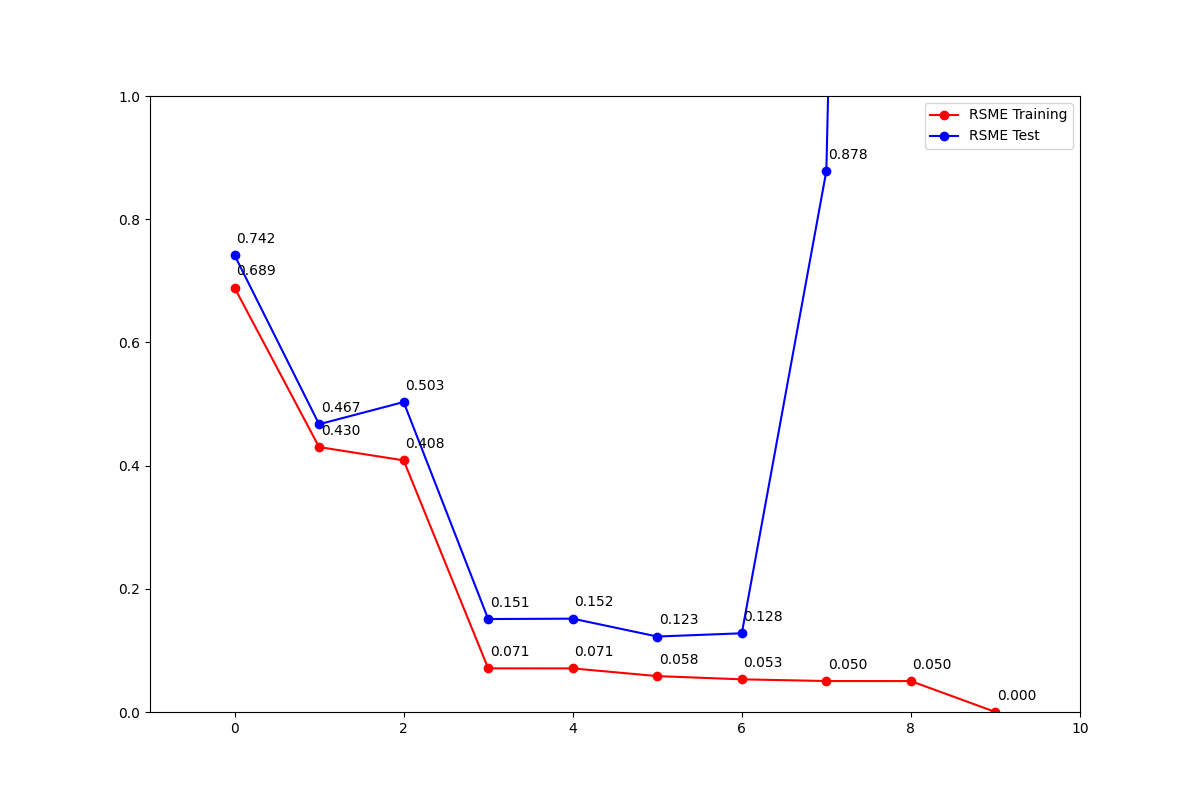

In [34]:
offset = .02

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(orders, rmse_train, linestyle='-', marker='o', color='r', label='RSME Training')
ax.plot(orders, rmse_test, linestyle='-', marker='o', color='b', label='RSME Test')
ax.set_ylim(bottom=0, top=1)
ax.set_xlim(left=-1, right=10)
for a, b, c in zip(orders, rmse_train, rmse_test):
    plt.text(a + offset, b + offset, '%.3f' % b)
    plt.text(a + offset, c + offset, '%.3f' % c)
ax.legend()
plt.show()

For $M = 9$ the training set error goes to zero, as we observed earlier because this polynomial contains 10 degrees of freedom corresponding to the 10 coefficients $w_0, ..., w_9$, and so can be tuned to the 10 data points in the training set.

The large difference in training and test error may seem paradoxical because a polynomial of a given order contains all lower-order polynomials as special cases. The $M = 9$ polynomial is therefore capable of generating results at leasts as good as the $M = 3$ polynomial. We also know a power series expansion of the function $sin(2 \pi x)$, contains terms of all orders, so we might expect that results should improve monotonically as we increase $M$.

We can gain some insight into the problem by examining the values of the coefficients $w^*$ obtained from polynomials from various orders.

In [35]:
for o in range(0, 10):
    polyreg = Pipeline([('p_features', PolynomialFeatures(o)), ('reg', LinearRegression())])
    polyreg.fit(X.reshape(-1, 1),y.reshape(-1, 1))
    term = f"{polyreg['reg'].intercept_[0]:.2f}"
    for i, w in enumerate(polyreg['reg'].coef_.tolist()[0][1:]):
        term += f" + {w:.2f} x^{i+1}"
    print(f"Polynomial with M = {o}: " + term)

Polynomial with M = 0: -0.20
Polynomial with M = 1: 0.73 + -1.80 x^1
Polynomial with M = 2: 1.01 + -3.67 x^1 + 1.93 x^2
Polynomial with M = 3: -0.51 + 13.64 x^1 + -38.29 x^2 + 25.52 x^3
Polynomial with M = 4: -0.53 + 13.94 x^1 + -39.58 x^2 + 27.50 x^3 + -0.99 x^4
Polynomial with M = 5: -0.28 + 8.25 x^1 + -1.80 x^2 + -71.30 x^3 + 109.53 x^4 + -44.30 x^5
Polynomial with M = 6: 0.05 + -1.50 x^1 + 85.77 x^2 + -403.47 x^3 + 712.75 x^4 + -564.68 x^5 + 171.45 x^6
Polynomial with M = 7: 7.41 + -233.71 x^1 + 2455.06 x^2 + -11332.43 x^3 + 26929.76 x^4 + -34583.69 x^5 + 22838.00 x^6 + -6082.27 x^7
Polynomial with M = 8: -66.56 + 2203.80 x^1 + -24622.58 x^2 + 131798.53 x^3 + -390056.10 x^4 + 675417.78 x^5 + -682489.03 x^6 + 373144.14 x^7 + -85340.66 x^8
Polynomial with M = 9: 6262.98 + -217310.46 x^1 + 2652955.72 x^2 + -16121524.94 x^3 + 56465047.43 x^4 + -121763155.50 x^5 + 164696369.92 x^6 + -136404048.78 x^7 + 63306265.33 x^8 + -12621420.55 x^9


We can see that, as $M$ increases, the magnitude of the coefficients gets larger. Intuitively, what is happening is that the more flexible polynomials with larger values of $M$ are increasingly tuned to the random noise on the target value instead of approximating the underlying sinus function.

Further insight can be gained by increasing the size of our training data set.

In [36]:
n_large = 100

X_large = np.random.random_sample(n_large, )
y_large = np.sin(2.*np.pi*X_large) + np.random.normal(0, 0.1,n_large)
X_large_sin = np.arange(0, 1, 0.01)
y_large_sin = np.sin(2*np.pi*X_large_sin)

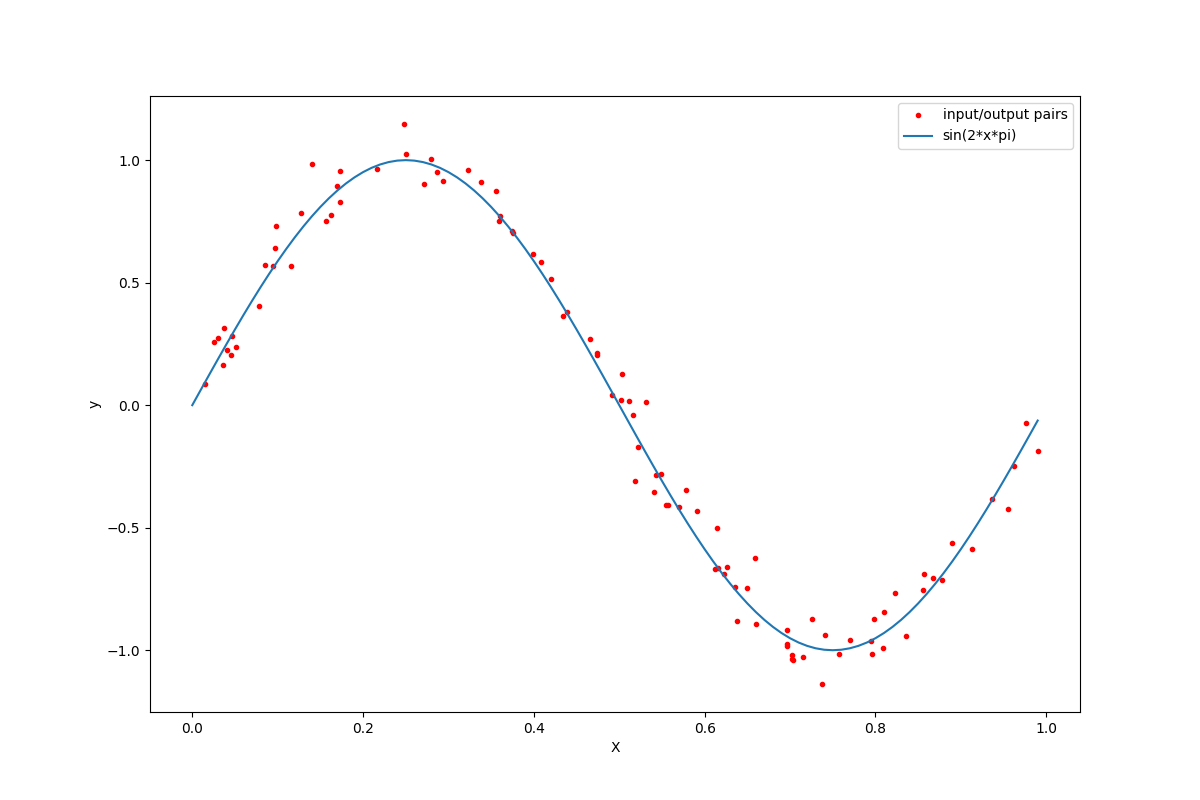

In [37]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(X_large, y_large, 'r.', label='input/output pairs')
ax.plot(X_large_sin, y_large_sin, label='sin(2*x*pi)')
ax.set_xlabel("X")
ax.set_ylabel("y")
ax.legend()

In [38]:
order = 9

polyreg = Pipeline([('p_features', PolynomialFeatures(order)), ('reg', LinearRegression())])
polyreg.fit(X_large.reshape(-1, 1),y_large.reshape(-1, 1))
X_large_reg_curve = np.linspace(0, 1, 300).reshape(-1, 1)
y_large_reg_curve = polyreg.predict(X_large_reg_curve)
y_large_reg = polyreg.predict(X_large.reshape(-1, 1))

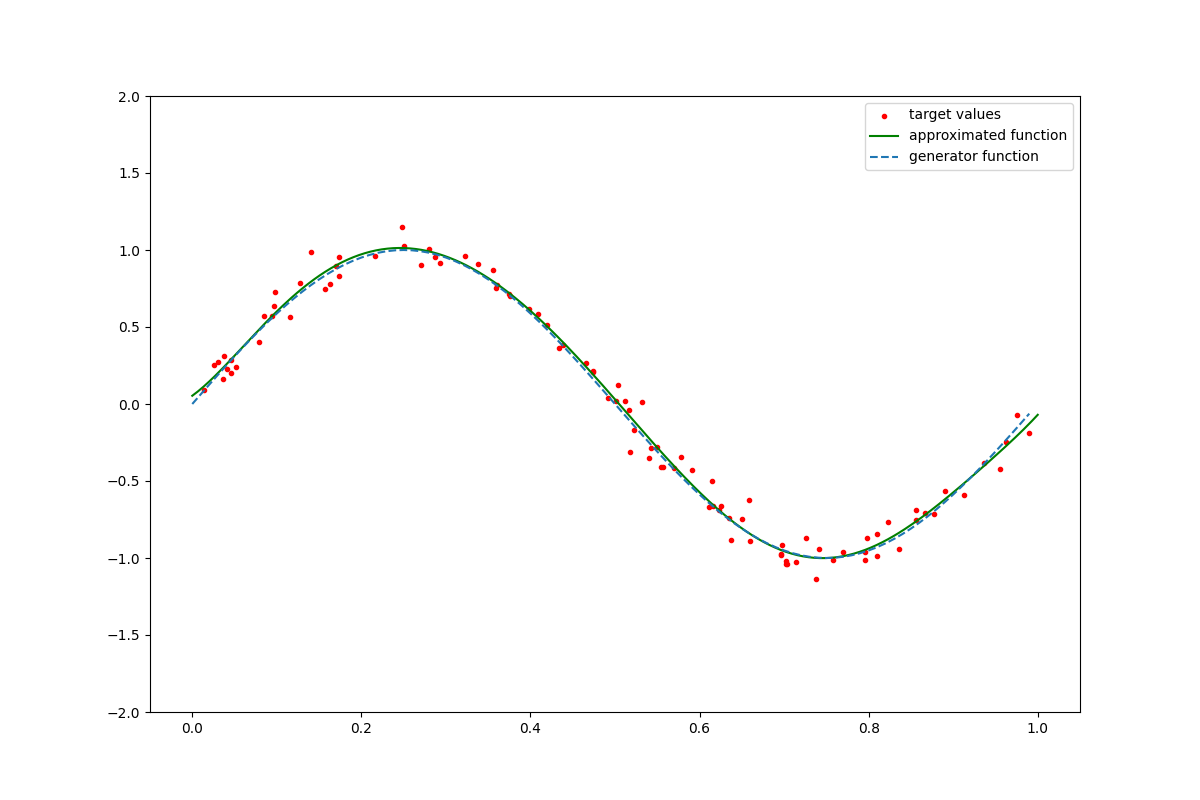

In [40]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(X_large, y_large, color="red", marker=".", label='target values')
ax.plot(X_large_reg_curve, y_large_reg_curve, color="green", label='approximated function')
ax.plot(X_large_sin, y_large_sin, linestyle='--', label='generator function')
ax.set_ylim(bottom=-2, top=2)
ax.legend()

We can also calculate the RMSE.

In [41]:
print(rmse(y_large_reg, y_large.reshape(-1, 1)))

0.07821231826718611


We can observe, that for a given model complexity, the over-fitting problem becomes less serve as the size of the data set increases. Another way to say this is that with a larger data set, we can afford to fit a more complex model to the data.

There is something rather unsatisfying about having to limit the number of parameters in a model according to the size of the available training set. It would seem more reasonable to choose the complexity of the model according to the complexity of the problem being solved.

One technique that is often used to control the over-fitting phenomenon, as an alternative to limiting the number of parameters, is that of ***regularization***, which involves adding a penalty term to the error function to disencourage the coefficients from having large magnitudes.

The simplest such penalty term takes the form of the sum of squares of all the coefficients, leading to a modified error function

$$\tilde{E}(w) = \frac{1}{2}\sum_{n=1}^N (\hat{y}(x_n, w) - y_n)^2 + \alpha ||w||_2^2$$

where

$$||w||_2^2 \equiv w^T w = w_0^2 + w_1^2 + ... + w_M^2$$

and the coefficient $\alpha$ governs the relative importance of the regularization term.

Let's visualize the effect of regularization on a model.

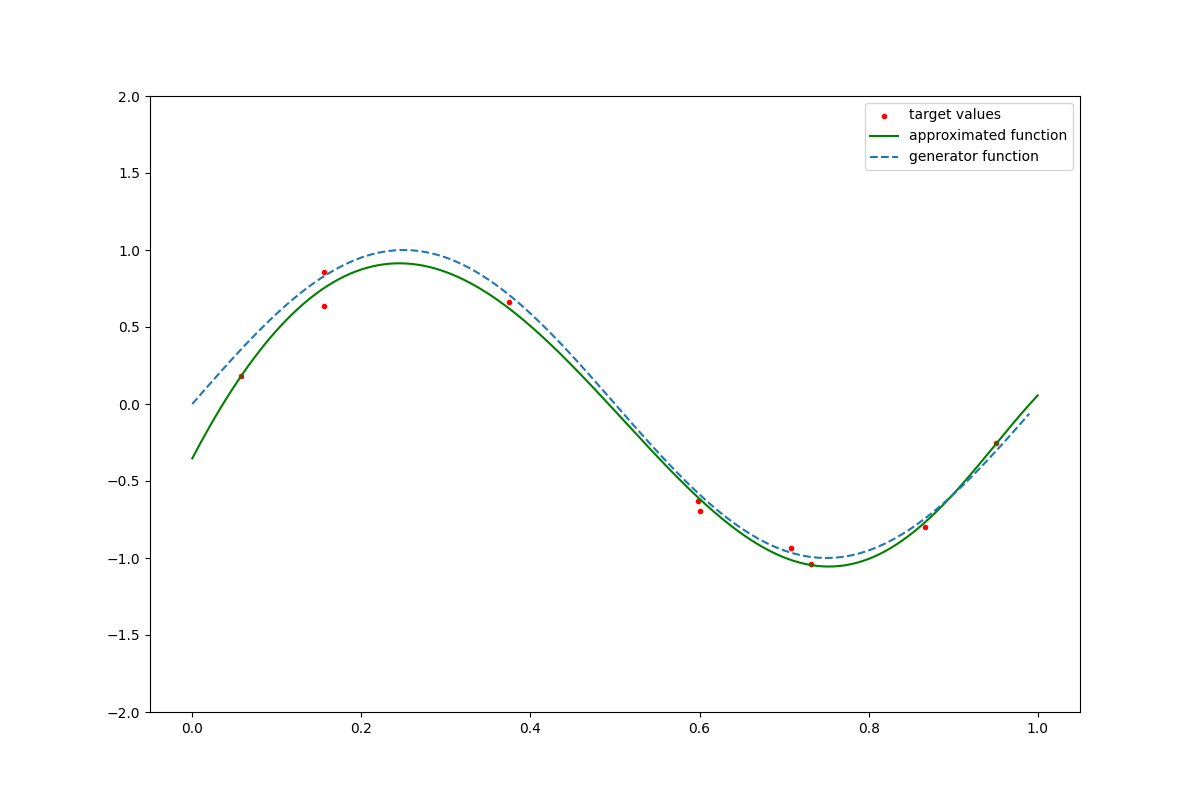

In [45]:
order = 9
alpha = 0.00001

polyreg = Pipeline([('p_features', PolynomialFeatures(order)), ('reg', Ridge(alpha=alpha))])
polyreg.fit(X.reshape(-1, 1),y.reshape(-1, 1))
X_reg_curve = np.linspace(0, 1, 300).reshape(-1, 1)
y_reg_curve = polyreg.predict(X_reg_curve)
y_reg = polyreg.predict(X.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(X, y, color="red", marker=".", label='target values')
ax.plot(X_reg_curve, y_reg_curve, color="green", label='approximated function')
ax.plot(X_sin, y_sin, linestyle='--', label='generator function')
ax.set_ylim(bottom=-2, top=2)
ax.legend()

The impact of the regularization term on the generalization error can be seen by plotting the value of the RMS error for both training and test sets against $\alpha$.

In [46]:
alphas = []
rmse_train = []
rmse_test = []

order = 9

for i in range(0, 12):
    polyreg = Pipeline([('p_features', PolynomialFeatures(order)),
                        ('reg', Ridge(alpha=(0.1**i)))])
    polyreg.fit(X.reshape(-1, 1),y.reshape(-1, 1))
    y_reg = polyreg.predict(X.reshape(-1, 1))
    y_reg_test = polyreg.predict(X_test.reshape(-1, 1))
    alphas.append(i)
    rmse_train.append(rmse(y_reg, y.reshape(-1, 1)))
    rmse_test.append(rmse(y_reg_test, y_test.reshape(-1, 1)))

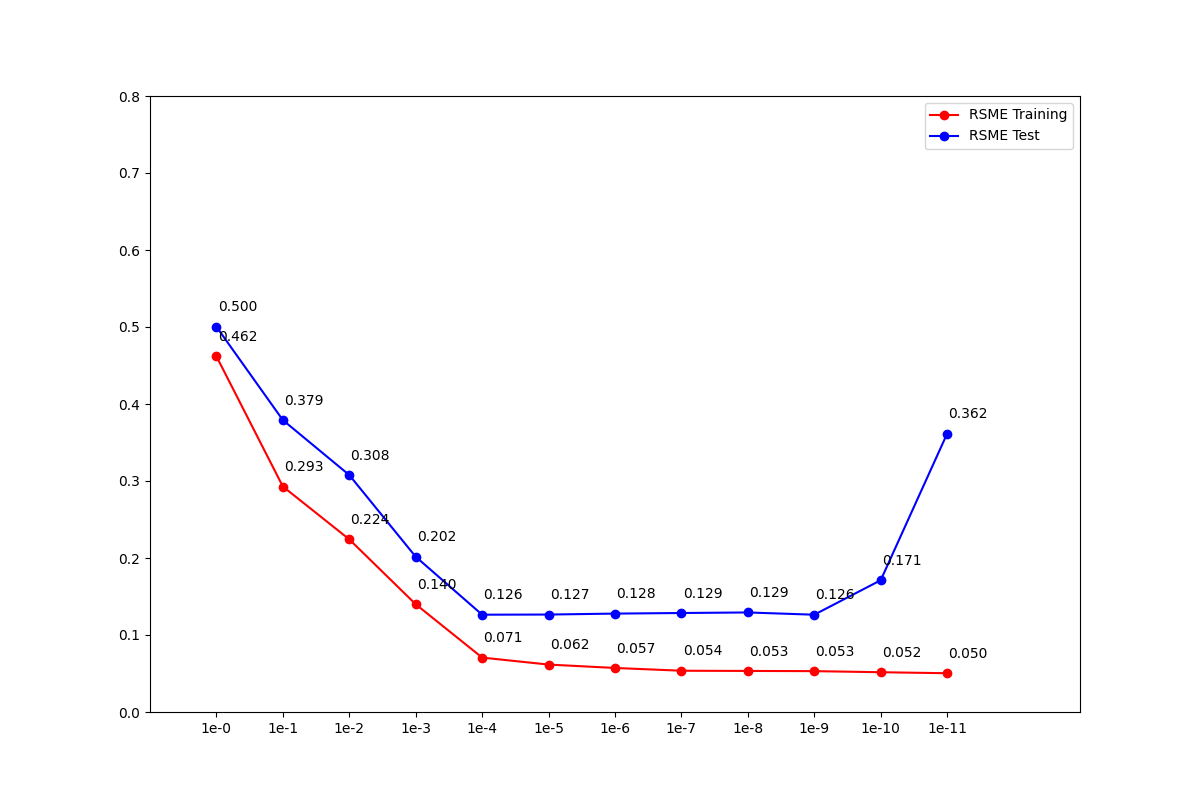

In [47]:
offset = .02

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(alphas, rmse_train, linestyle='-', marker='o', color='r', label='RSME Training')
ax.plot(alphas, rmse_test, linestyle='-', marker='o', color='b', label='RSME Test')
ax.set_ylim(bottom=0, top=.8)
ax.set_xlim(left=-1, right=13)
ax.set_xticks(alphas, labels=[f"1e-{x}" for x in alphas])
for a, b, c in zip(alphas, rmse_train, rmse_test):
    plt.text(a + offset, b + offset, '%.3f' % b)
    plt.text(a + offset, c + offset, '%.3f' % c)
ax.legend()
plt.show()

We see that $\alpha$ now controls the effective complexity of the model and hence determines the degree of over-fitting.

The quantity $\alpha$ is an example of a ***hyperparameter*** whose values are fixed during the minimiziation of the error function to determine the model parameters $w$. We can not simply determine the value of $\alpha$ by minimizing the error function jointly with respect to $w$ and $\alpha$ since this will lead to $\alpha \rightarrow 0$ and an overfitted model with small or zero training error.

Similarly, the order $M$ of the polynomial is a hyperparameter of the model, and simply optimizing the training set error with respect to $M$ will lead to large values of $M$ and associated over-fitting. We therefore need to find a way to determine suitable values for hyperparameters.

The results above suggest a simple way of achieving this, namely by taking the available data and partitioning it into a training set, used to determine the coefficients $w$, and a seperate ***validation set***. We then select the model having the lowest error on the validation set.

If the model design is iterated many times using a data set of limited size, then some over-fitting to the validation data can occur, and so it may be necessary to keep aside a third ***test set*** on which the performance of the selected model can finally be evaluated.

<figure>
<img src="https://github.com/bbirke/ml-python/blob/main/images/ml_splits.png?raw=true" alt="ai-ml-dl" width="600"/>
<figcaption>Fig.1 - A typical split of a data set. The <i>training set</i> is used to tune the learnable model coefficients. The <i>validation set</i> is used to tune the model hyperparameters and select the best performing model. The <i>test set</i> is used for a final evaluation of the selected model. </figcaption>
</figure>

For some applications, the supply of data for training and testing will be limited. To build a good model, we should use as much of the available data as possible for training. However, if the validation set is too small, it will give a relative noisy estimate of predictive performance.

One solution to this problem is to use ***K-fold cross-validation***. This allows a portion of $(K-1)/K$ of the available data to be used for training while making use of all the data to assess performance.

<figure>
<img src="https://github.com/bbirke/ml-python/blob/main/images/ml_cv_splits.png?raw=true" alt="ai-ml-dl" width="600"/>
<figcaption>Fig.2 - K-fold cross-validation, illustrated here on the case of K = 5, involves taking the available data and partitioning it into K groups of equal size. Then K - 1 of the groups are used to train a set of models that are then evaluated on the remaining group. This process is then repeated for all K possible choises for the held-out group, indicated here by red blocks, and the performance scores from the K runs are then averaged.</figcaption>
</figure>

The main drawback of cross-validation is that the number of training runs that must be performed is increased by the factor $K$, and this can prove problematic for models in which the training is itself computationally expensive.

A further problem with techniques such as cross-validation that use seperate data to assess performance is that we might have multiple complexity hyperparameters for a single model. Exploring combinations of settings for such hyperparameters could, in the worst case, require a number of training runs that is exponential in the number of hyperparameters.

The state of the art in modern ML involves extremely large models, trained on commensurately large data sets. Consequently, there is limited scope for exploration of hyperparameter settings, and heavy reliance is placed on experience obtained with smaller models and on heuristics.